Teams data shape: (378, 4)
Regular season data shape: (31200, 34)
Tournament seeds data shape: (340, 3)
Seasons data shape: (6, 6)
Seasons included: [2019 2020 2021 2022 2023 2024]

Number of teams that made the tournament: 340

Sample of tournament teams with their seeds and regions:
    Season        TeamName TournamentSeed TournamentRegion    WinPct
0     2019     Abilene Chr             15          Midwest  0.793103
2     2021     Abilene Chr             14             East  0.826087
15    2022           Akron             13             East  0.709677
17    2024           Akron             14          Midwest  0.687500
20    2021         Alabama              2             East  0.800000
21    2022         Alabama              6             West  0.593750
22    2023         Alabama              1            South  0.852941
23    2024         Alabama              4             West  0.656250
56    2021  Appalachian St             16             West  0.541667
63    2022         Arizo

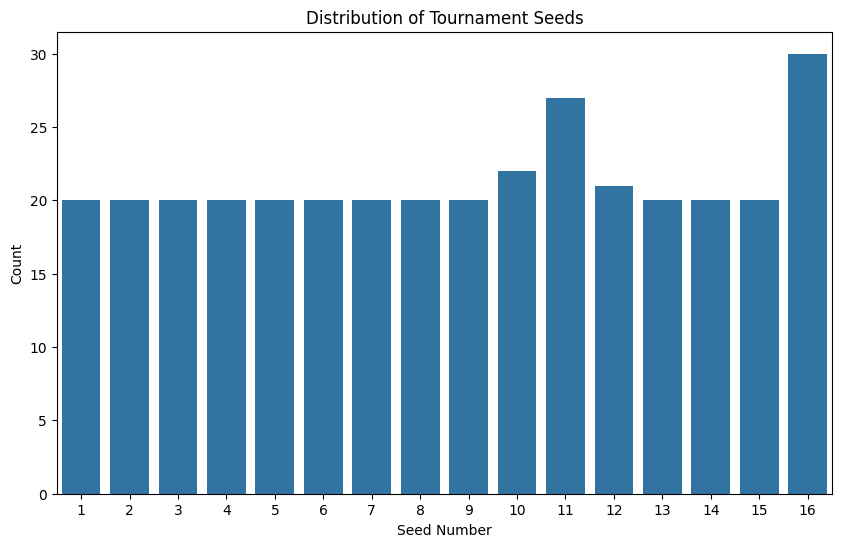

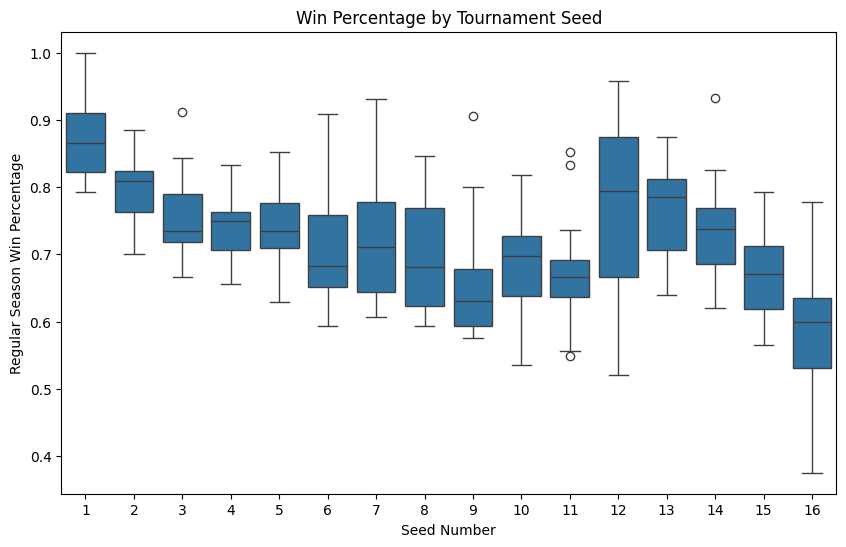

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the data
teams = pd.read_csv('../Data/MTeams.csv')
regular_season = pd.read_csv('../Data/MRegularSeasonDetailedResults.csv')
tournament_seeds = pd.read_csv('../Data/MNCAATourneySeeds.csv')
seasons = pd.read_csv('../Data/MSeasons.csv')

# Filter for seasons 2019-2024
regular_season = regular_season[regular_season['Season'] >= 2019]
tournament_seeds = tournament_seeds[tournament_seeds['Season'] >= 2019]
seasons = seasons[seasons['Season'] >= 2019]

# Display data info
print(f"Teams data shape: {teams.shape}")
print(f"Regular season data shape: {regular_season.shape}")
print(f"Tournament seeds data shape: {tournament_seeds.shape}")
print(f"Seasons data shape: {seasons.shape}")
print(f"Seasons included: {regular_season['Season'].unique()}")

# Function to calculate team statistics for a single season
def calculate_team_stats(team_id, season_data):
    """Calculate all requested statistics for a team in a specific season"""
    
    # Filter games where team participated (as winner or loser)
    team_games_won = season_data[season_data['WTeamID'] == team_id]
    team_games_lost = season_data[season_data['LTeamID'] == team_id]
    total_games = len(team_games_won) + len(team_games_lost)
    
    if total_games == 0:
        return None  # No games in this season
    
    stats = {}
    stats['Season'] = season_data['Season'].iloc[0] if len(season_data) > 0 else None
    stats['TeamID'] = team_id
    stats['Games'] = total_games
    
    # Points per game
    points_scored = team_games_won['WScore'].sum() + team_games_lost['LScore'].sum()
    stats['PointsPerGame'] = points_scored / total_games
    
    # Points allowed per game
    points_allowed = team_games_won['LScore'].sum() + team_games_lost['WScore'].sum()
    stats['PointsAllowedPerGame'] = points_allowed / total_games
    
    # Field goal percentages
    fgm = team_games_won['WFGM'].sum() + team_games_lost['LFGM'].sum()
    fga = team_games_won['WFGA'].sum() + team_games_lost['LFGA'].sum()
    fgm3 = team_games_won['WFGM3'].sum() + team_games_lost['LFGM3'].sum()
    fga3 = team_games_won['WFGA3'].sum() + team_games_lost['LFGA3'].sum()
    
    stats['FG%'] = fgm / fga if fga > 0 else 0
    stats['3PT%'] = fgm3 / fga3 if fga3 > 0 else 0
    stats['2PT%'] = (fgm - fgm3) / (fga - fga3) if (fga - fga3) > 0 else 0
    stats['3PTAttemptsPerGame'] = fga3 / total_games
    
    # Rebounds
    offensive_rebounds = team_games_won['WOR'].sum() + team_games_lost['LOR'].sum()
    defensive_rebounds = team_games_won['WDR'].sum() + team_games_lost['LDR'].sum()
    total_rebounds = offensive_rebounds + defensive_rebounds
    
    stats['ReboundsPerGame'] = total_rebounds / total_games
    stats['OffensiveReboundsPerGame'] = offensive_rebounds / total_games
    stats['DefensiveReboundsPerGame'] = defensive_rebounds / total_games
    
    # Opponent rebounds
    opp_offensive_rebounds = team_games_won['LOR'].sum() + team_games_lost['WOR'].sum()
    opp_defensive_rebounds = team_games_won['LDR'].sum() + team_games_lost['WDR'].sum()
    opp_total_rebounds = opp_offensive_rebounds + opp_defensive_rebounds
    
    stats['OppReboundsPerGame'] = opp_total_rebounds / total_games
    stats['OppOffensiveReboundsPerGame'] = opp_offensive_rebounds / total_games
    
    # Turnovers and steals
    turnovers = team_games_won['WTO'].sum() + team_games_lost['LTO'].sum()
    opp_turnovers = team_games_won['LTO'].sum() + team_games_lost['WTO'].sum()
    steals = team_games_won['WStl'].sum() + team_games_lost['LStl'].sum()
    
    stats['TurnoversPerGame'] = turnovers / total_games
    stats['ForcedTurnoversPerGame'] = opp_turnovers / total_games
    stats['StealsPerGame'] = steals / total_games
    
    # Blocks
    blocks = team_games_won['WBlk'].sum() + team_games_lost['LBlk'].sum()
    stats['BlocksPerGame'] = blocks / total_games
    
    # Free throws
    fta = team_games_won['WFTA'].sum() + team_games_lost['LFTA'].sum()
    ftm = team_games_won['WFTM'].sum() + team_games_lost['LFTM'].sum()
    
    stats['FTAttemptsPerGame'] = fta / total_games
    stats['FT%'] = ftm / fta if fta > 0 else 0
    
    # Win percentage
    stats['Wins'] = len(team_games_won)
    stats['Losses'] = len(team_games_lost)
    stats['WinPct'] = len(team_games_won) / total_games if total_games > 0 else 0
    
    # Note: For clutch games and points off turnovers, we'd need more data
    # These are approximations or placeholders
    stats['ClutchGames'] = 'N/A'  # Would need game flow data
    stats['ClutchRecord'] = 'N/A'  # Would need game flow data
    
    return stats

# Function to add tournament seed and region information
def add_tournament_info(team_stats_df, tournament_seeds, seasons):
    """Add NCAA Tournament seed and region information to team stats."""
    
    # Create a copy of team_stats_df to avoid modifying the original
    enhanced_df = team_stats_df.copy()
    
    # Add columns for tournament information
    enhanced_df['TournamentSeed'] = None
    enhanced_df['TournamentRegion'] = None
    enhanced_df['MadeTournament'] = False
    
    # Process each team for each season
    for index, row in enhanced_df.iterrows():
        team_id = row['TeamID']
        season = row['Season']
        
        # Look up tournament seed information
        seed_info = tournament_seeds[(tournament_seeds['TeamID'] == team_id) & 
                                   (tournament_seeds['Season'] == season)]
        
        if len(seed_info) > 0:
            # Team made the tournament
            enhanced_df.at[index, 'MadeTournament'] = True
            seed_code = seed_info['Seed'].iloc[0]
            region_letter = seed_code[0]  # Extract W, X, Y, or Z
            seed_number = seed_code[1:3]  # Extract the seed number (01-16)
            
            # Get actual region name
            season_info = seasons[seasons['Season'] == season]
            if len(season_info) > 0:
                if region_letter == 'W':
                    region_name = season_info['RegionW'].iloc[0]
                elif region_letter == 'X':
                    region_name = season_info['RegionX'].iloc[0]
                elif region_letter == 'Y':
                    region_name = season_info['RegionY'].iloc[0]
                elif region_letter == 'Z':
                    region_name = season_info['RegionZ'].iloc[0]
                else:
                    region_name = None
                    
                enhanced_df.at[index, 'TournamentSeed'] = int(seed_number)
                enhanced_df.at[index, 'TournamentRegion'] = region_name
    
    return enhanced_df

# Process all teams for seasons 2019-2024
all_stats = []

# Get unique seasons
seasons_list = sorted(regular_season['Season'].unique())

# Process each team for each season
for team_id in teams['TeamID']:
    team_name = teams[teams['TeamID'] == team_id]['TeamName'].iloc[0]
    
    for season in seasons_list:
        season_data = regular_season[regular_season['Season'] == season]
        team_stats = calculate_team_stats(team_id, season_data)
        
        if team_stats:  # If team played in this season
            team_stats['TeamName'] = team_name
            all_stats.append(team_stats)

# Create DataFrame of all team stats
team_stats_df = pd.DataFrame(all_stats)

# Add tournament information
team_stats_df = add_tournament_info(team_stats_df, tournament_seeds, seasons)

# Display first few rows
team_stats_df.head()

# Display teams that made the tournament
tournament_teams = team_stats_df[team_stats_df['MadeTournament'] == True]
print(f"\nNumber of teams that made the tournament: {len(tournament_teams)}")
print("\nSample of tournament teams with their seeds and regions:")
print(tournament_teams[['Season', 'TeamName', 'TournamentSeed', 'TournamentRegion', 'WinPct']].head(10))

# Example: Get UNC stats specifically (assuming UNC's TeamID is in the data)
# Find UNC's TeamID
unc_teams = teams[teams['TeamName'].str.contains('North Carolina', case=False)]
print("North Carolina teams in the dataset:")
print(unc_teams)

# If UNC is found, filter for their stats
if len(unc_teams) > 0:
    unc_id = unc_teams['TeamID'].iloc[0]  # Take first match
    unc_stats = team_stats_df[team_stats_df['TeamID'] == unc_id]
    print("\nUNC Stats by Season:")
    print(unc_stats[['Season', 'PointsPerGame', 'PointsAllowedPerGame', 'FG%', 
                      '3PT%', 'ReboundsPerGame', 'WinPct', 'TournamentSeed', 'TournamentRegion']])

# Save the processed data
team_stats_df.to_csv('../processed_team_stats_2019_2024.csv', index=False)
print(f"\nProcessed stats for {team_stats_df['TeamID'].nunique()} teams across {len(seasons_list)} seasons")

# Analyze tournament seed distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=tournament_teams, x='TournamentSeed')
plt.title('Distribution of Tournament Seeds')
plt.xlabel('Seed Number')
plt.ylabel('Count')
plt.show()

# Analyze win percentage by tournament seed
plt.figure(figsize=(10, 6))
sns.boxplot(data=tournament_teams, x='TournamentSeed', y='WinPct')
plt.title('Win Percentage by Tournament Seed')
plt.xlabel('Seed Number')
plt.ylabel('Regular Season Win Percentage')
plt.show()